# Part 2: During the training
During the training your asked to copy and paste the following code blocks into your script. 

## <p style="color:blue;">Part 2.1: Astro-Pi Replay tool</p>

We simulate taking a picture with the picamera and taking a reading with the SenseHat.
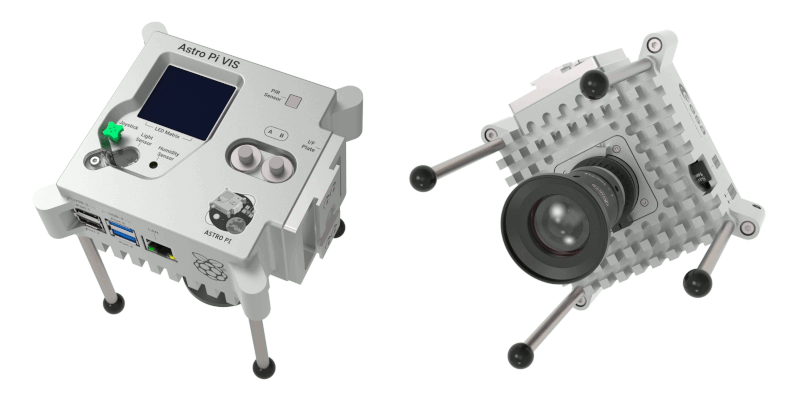


In [ ]:
# Import the PiCamera class from the picamera module
from picamera import PiCamera

# Create an instance of the PiCamera class
cam = PiCamera()

# Set the resolution of the camera to 4056×3040 pixels
cam.resolution = (4056, 3040)

# Capture an image, update folder
cam.capture("image1.jpg")
cam.capture("image2.jpg")

In [ ]:
# Import SenseHat class from sense_hat module
from sense_hat import SenseHat

# Create instance of the SenseHat class
sense = SenseHat()
sense.clear()

# Take pressure and temperature reading
pressure = sense.get_pressure()
temperature = sense.get_temperature()

print(pressure, temperature)

## <p style="color:blue;">Part 2.2: Calculate the speed of the ISS using photos</p>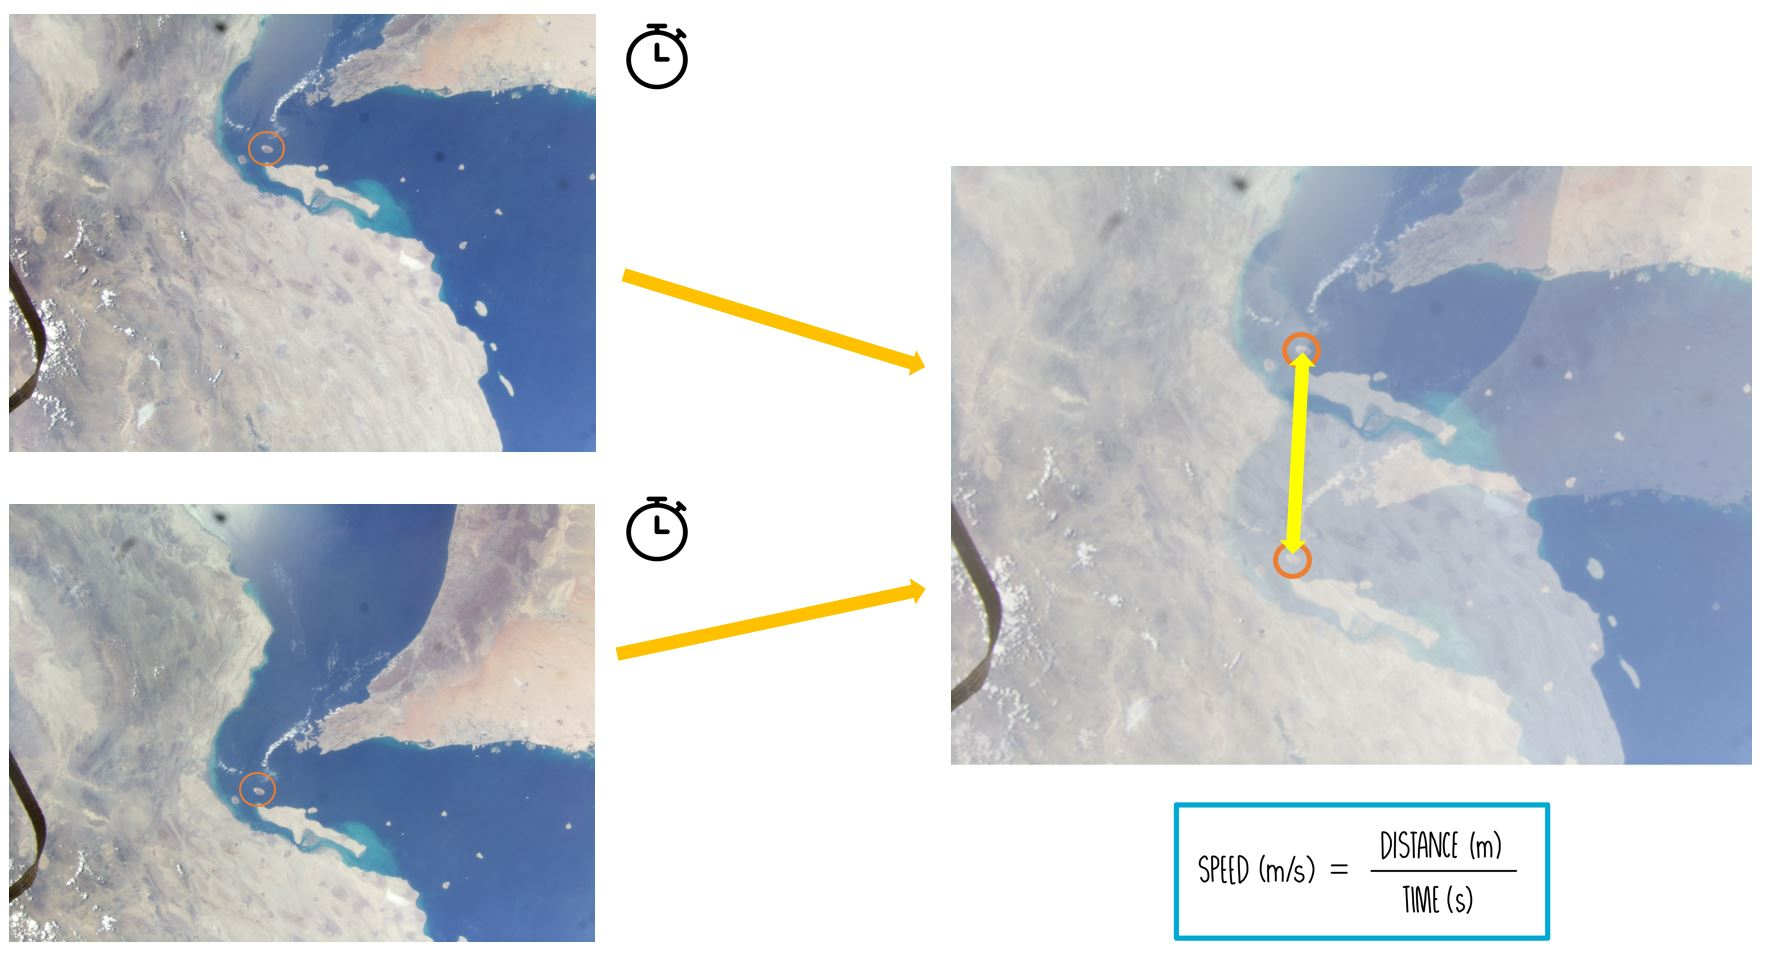

## Block A: Use EXIF data to find a time difference


In [ ]:
from exif import Image
from datetime import datetime

image_1 = 'photo_0683.jpg'
image_2 = 'photo_0684.jpg'

# function to extract the timestring from a photo and convert it to a datetime object
def get_time(image):
    with open(image, 'rb') as image_file:
        img = Image(image_file)
        
        time_str = img.get("datetime_original")
        time = datetime.strptime(time_str, '%Y:%m:%d %H:%M:%S')
        
        # this shows all the EXIF data you can extract from a photo
        for data in img.list_all():
            print(data)
            
    return time

# calling the function
time_1 = get_time(image_1)
time_2 = get_time(image_2)

print(time_1, time_2)

In [ ]:
# function to calculate the time difference between two photo's
def get_time_difference(image_1, image_2):
    time_1 = get_time(image_1)
    time_2 = get_time(image_2)
    time_difference = time_2 - time_1
    
    return time_difference

# calling the function
time_difference = get_time_difference(image_1, image_2)

print(time_difference)

## Block B: Find matching features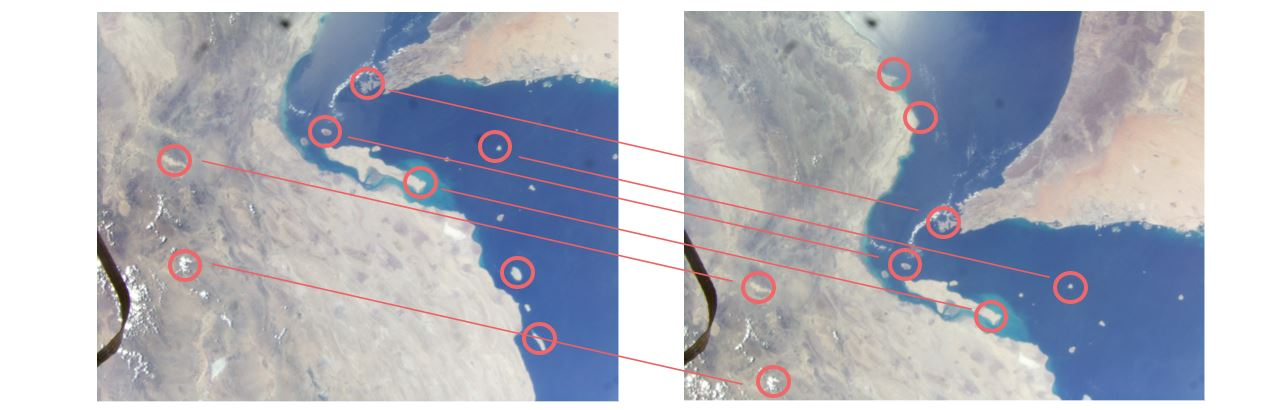

Install opencv-python package.<br>
Click on <b>Tools > Manage packages..</b> and search for <b>opencv-python</b><br>
Hit install and restart<br>

In [ ]:
import cv2
import math

In [ ]:
# convert the images to OpenCV objects so they can be processed
def convert_to_cv(image_1, image_2):
    image_1_cv = cv2.imread(image_1, 0)
    image_2_cv = cv2.imread(image_2, 0)
    return image_1_cv, image_2_cv

# using the ORB algorithm to extract keypoints and descriptors in a photo
def calculate_features(image_1_cv, image_2_cv, feature_number):
    orb = cv2.ORB_create(nfeatures = feature_number)
    keypoints_1, descriptors_1 = orb.detectAndCompute(image_1_cv, None)
    keypoints_2, descriptors_2 = orb.detectAndCompute(image_2_cv, None)
    return keypoints_1, keypoints_2, descriptors_1, descriptors_2

# comparing the descriptors to find matching keypoints using a Brute Force algorithm
def calculate_matches(descriptors_1, descriptors_2):
    brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = brute_force.match(descriptors_1, descriptors_2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

In [ ]:
# calling all functions
time_difference = get_time_difference(image_1, image_2) # Get time difference between images
image_1_cv, image_2_cv = convert_to_cv(image_1, image_2) # Create OpenCV image objects
keypoints_1, keypoints_2, descriptors_1, descriptors_2 = calculate_features(image_1_cv, image_2_cv, 1000) # Get keypoints and descriptors
matches = calculate_matches(descriptors_1, descriptors_2) # Match descriptors

print(matches)

# Block C: Display matches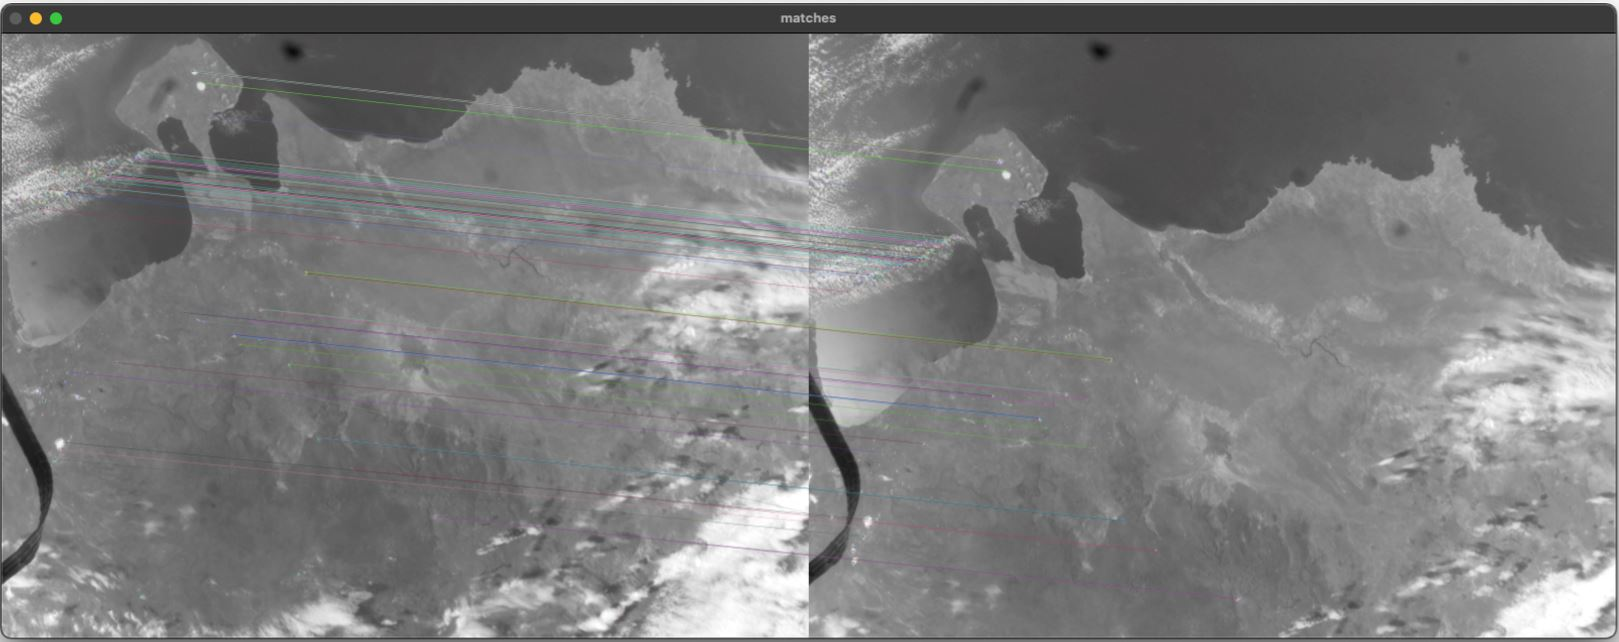

In [ ]:
# function to display matches in an image, you can insert how many matches you want to display
def display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches):
    match_img = cv2.drawMatches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches[:100], None)
    resize = cv2.resize(match_img, (1600,600), interpolation = cv2.INTER_AREA)
    cv2.imshow('matches', resize)
    cv2.waitKey(0)
    cv2.destroyWindow('matches')

In [ ]:
display_matches(image_1_cv, keypoints_1, image_2_cv, keypoints_2, matches) # Display matches

# Block D: Find matching coordinates

In [ ]:
# function to extract coordinates from matching keypoints
def find_matching_coordinates(keypoints_1, keypoints_2, matches):
    coordinates_1 = []
    coordinates_2 = []
    for match in matches:
        image_1_idx = match.queryIdx
        image_2_idx = match.trainIdx
        (x1,y1) = keypoints_1[image_1_idx].pt
        (x2,y2) = keypoints_2[image_2_idx].pt
        coordinates_1.append((x1,y1))
        coordinates_2.append((x2,y2))
    return coordinates_1, coordinates_2

In [ ]:
coordinates_1, coordinates_2 = find_matching_coordinates(keypoints_1, keypoints_2, matches)

print(coordinates_1[0], coordinates_2[0])

# Block E: Calculate feature distance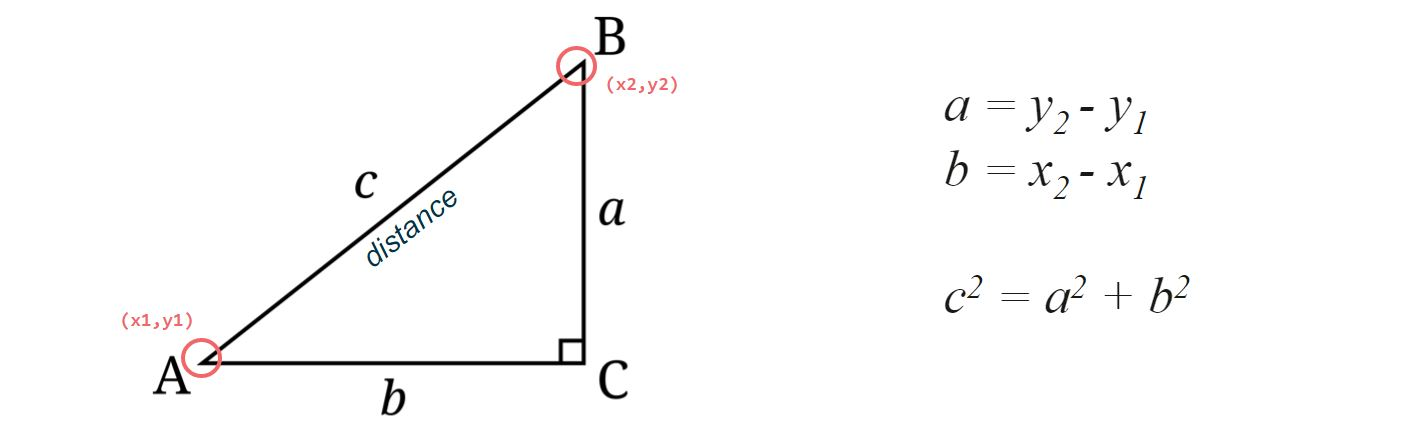

In [ ]:
# calculate distance between matching keypoints with Pythagoras
def calculate_mean_distance(coordinates_1, coordinates_2):
    all_distances = 0
    merged_coordinates = list(zip(coordinates_1, coordinates_2))
    for coordinate in merged_coordinates:
        x_difference = coordinate[0][0] - coordinate[1][0]
        y_difference = coordinate[0][1] - coordinate[1][1]
        distance = math.hypot(x_difference, y_difference)
        all_distances = all_distances + distance
    average = all_distances / len(merged_coordinates)
    return average

In [ ]:
average_feature_distance = calculate_mean_distance(coordinates_1, coordinates_2)

print(average_feature_distance)

# Block F: Calculate average speed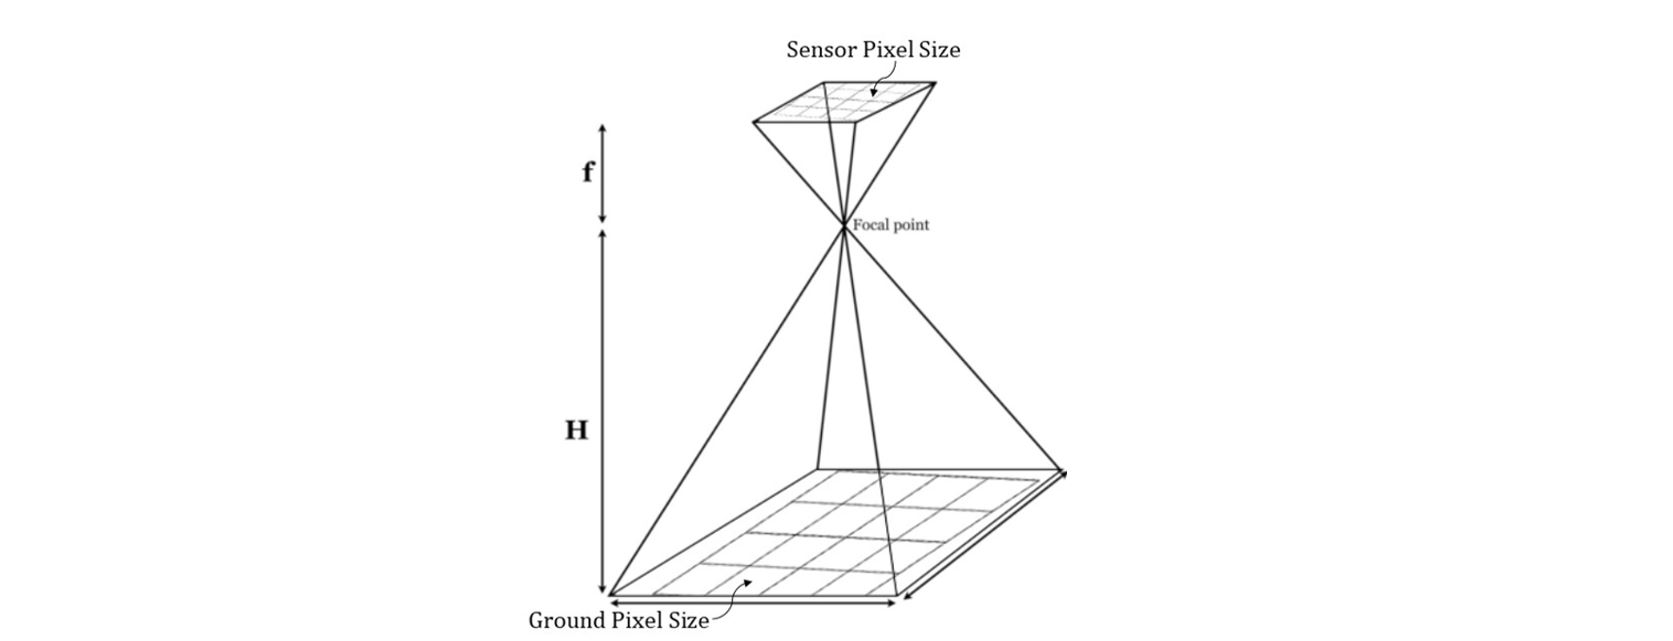

In [ ]:
# function to convert pixel distance to distance with GSD and calculating the speed in km/s
def calculate_speed_in_kmps(feature_distance, GSD, time_difference):
    distance = feature_distance * GSD / 100000 # convert pixels to distance in km
    speed = distance / time_difference
    return speed

def format_speed(speed, nr_of_digits):
    exponent = int(math.floor(math.log10(abs(speed))))
    decimals = nr_of_digits - 1 - exponent
    speed_formatted = "{:.{}f}".format(speed, decimals)
    
    return speed_formatted

In [ ]:
GSD = 12648 # for a resolution of 4056 x 3040, recalculate GSD for different resolutions
speed = calculate_speed_in_kmps(average_feature_distance, GSD, time_difference)
speed_formatted = format_speed(speed, 5)

print(speed_formatted)

## <p style="color:blue;">Part 2.3: Test with astro-pi-replay and write results file</p>


In [ ]:
# Import the PiCamera class from the picamera module
from picamera import PiCamera

# Create an instance of the PiCamera class
cam = PiCamera()

# Set the resolution of the camera to 4056×3040 pixels
cam.resolution = (4056, 3040)

# Capture two images
cam.capture("image1.jpg")
cam.capture("image2.jpg")

image_1 = 'image1.jpg'
image_2 = 'image2.jpg'

In [ ]:
with open('result.txt', 'w') as file:
    file.write(speed_formatted)
    
print("Data written to result.txt")